# BAO examples

In this notebook we will show how to perform BAO fits to data power spectrum.
Look first at notebooks basic_examples.ipynb to get a flavor of *desilike* mechanisms.

## Fake power spectrum data

In [1]:
import numpy as np

from cosmoprimo.fiducial import DESI

cosmo = DESI()
edges = np.linspace(0., 0.3, 31)
k = (edges[:-1] + edges[1:]) / 2.
nmodes = 4. * np.pi / 3. * (edges[1:]**3 - edges[:-1]**3)
z = 1.
pk = cosmo.get_fourier().pk_interpolator(of='delta_cb')(k, z=z)
b = 2.
f = cosmo.growth_rate(z)
shotnoise = 1 / 5e-4
volume = 1e10

ells = (0, 2, 4)
poles = []
poles.append((b**2 + 2. / 3. * f * b + 1. / 5. * f**2) * pk + shotnoise)
poles.append((4. / 3. * f * b + 4. / 7. * f**2) * pk)
poles.append(8. / 35 * f**2 * pk)
poles = np.array(poles, dtype='f8')

from pypower import PowerSpectrumStatistics
mean = PowerSpectrumStatistics(edges, k, poles, nmodes=nmodes, ells=ells, shotnoise_nonorm=shotnoise, statistic='multipole')
cov = [2. * (2. * np.pi)**3 / (2 * ell + 1) / (volume * nmodes) * poles[0]**2 for ell in ells]
cov = np.diag(np.concatenate(cov, axis=0))

rng = np.random.RandomState(seed=42)
mocks = []
for i in range(1001):
    tmp = mean.deepcopy()
    tmp.power_nonorm.flat[...] = rng.multivariate_normal(mean.power_nonorm.ravel(), cov)
    mocks.append(tmp)
data, mocks = mocks[0], mocks[1:]

## BAO likelihood

In [2]:
from desilike.theories.galaxy_clustering import BAOPowerSpectrumTemplate, DampedBAOWigglesTracerPowerSpectrumMultipoles
from desilike.observables.galaxy_clustering import ObservedTracerPowerSpectrumMultipoles
from desilike.likelihoods import GaussianLikelihood
from desilike.parameter import ParameterCollection, ParameterPrior
from desilike import setup_logging


template = BAOPowerSpectrumTemplate(z=z, fiducial='DESI')
theory = DampedBAOWigglesTracerPowerSpectrumMultipoles(template=template)
# Set damping sigmas to zero, as data follows linear pk
for param in theory.params.select(basename='sigma*'):
    param.value = 0.
    param.fixed = True
# Fix some broadband parameters (those with k^{-3} and k^{-2}) to speed up calculation in this notebook
for param in theory.params.select(basename=['al*_-3', 'al*_-2']):
    param.value = 0.
    param.fixed = True
observable = ObservedTracerPowerSpectrumMultipoles(data=data, mocks=mocks,
                                                   klim={0: [0.005, 0.2], 2: [0.005, 0.2]}, # fit monopole and quadrupole, between 0.02 and 0.2 h/Mpc
                                                   kstep=0.01, theory=theory)
likelihood = GaussianLikelihood(observables=[observable])

setup_logging()
likelihood()  # just to initialize
print(likelihood.varied_params)

[000000.12] [0/1] 12-05 10:18  GaussianLikelihood        INFO     Covariance matrix with 40 points built from 1000 observations.
[000000.12] [0/1] 12-05 10:18  GaussianLikelihood        INFO     ...resulting in Hartlap factor of 0.9590.
[000000.14] [0/1] 12-05 10:18  absl                      INFO     Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 
[000000.14] [0/1] 12-05 10:18  absl                      INFO     Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
[000000.14] [0/1] 12-05 10:18  absl                      INFO     Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
[000000.14] [0/1] 12-05 10:18  absl                      INFO     Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.
[000000.14] [0/1] 12-05 10:18  absl                      WARNING  No GPU/TPU found, falling back to CP

/home/adematti/Bureau/DESI/NERSC/cosmodesi/cosmoprimo/cosmoprimo/eisenstein_hu.py:23: UserWarning: EisensteinHuNoWiggleEngine cannot cope with massive neutrinos
  warnings.warn('{} cannot cope with massive neutrinos'.format(self.__class__.__name__))


## Fit
Let us perform some likelihood (actually posterior, including parameter priors) profiling.

In [3]:
from desilike.profilers import MinuitProfiler

# Seed used to decide on starting point
profiler = MinuitProfiler(likelihood, seed=42)
# Find best fit, starting from 5 different starting points
# NOTE: With MPI, these runs are performed in parallel
profiler.maximize(niterations=3)

[000000.78] [0/1] 12-05 10:18  MinuitProfiler            INFO     Varied parameters: ['qpar', 'qper', 'b1', 'al0_-1', 'al0_0', 'al0_1', 'al2_-1', 'al2_0', 'al2_1'].


In [4]:
print(profiler.profiles.to_stats(tablefmt='pretty'))

+--------------+--------+---------+--------+
| chi2 = 23.18 | varied | bestfit | error  |
+--------------+--------+---------+--------+
|     qpar     |  True  | 1.0014  | 0.0027 |
|     qper     |  True  | 0.9955  | 0.0049 |
|      b1      |  True  |  1.976  | 0.023  |
|    al0_-1    |  True  |   190   |  160   |
|    al0_0     |  True  |   -80   |  240   |
|    al0_1     |  True  |   24    |  100.  |
|    al2_-1    |  True  |   33    |  60.   |
|    al2_0     |  True  |  -110.  |  100.  |
|    al2_1     |  True  |   47    |  40.   |
+--------------+--------+---------+--------+


array([<AxesSubplot:ylabel='$\\alpha_{\\parallel}$'>,
       <AxesSubplot:ylabel='$\\alpha_{\\perp}$'>], dtype=object)

[000011.52] [0/1] 12-05 10:18  matplotlib.mathtext       INFO     Substituting symbol \perp from STIXGeneral
[000011.52] [0/1] 12-05 10:18  matplotlib.mathtext       INFO     Substituting symbol \perp from STIXGeneral
[000011.57] [0/1] 12-05 10:18  matplotlib.mathtext       INFO     Substituting symbol \perp from STIXGeneral
[000011.57] [0/1] 12-05 10:18  matplotlib.mathtext       INFO     Substituting symbol \perp from STIXGeneral


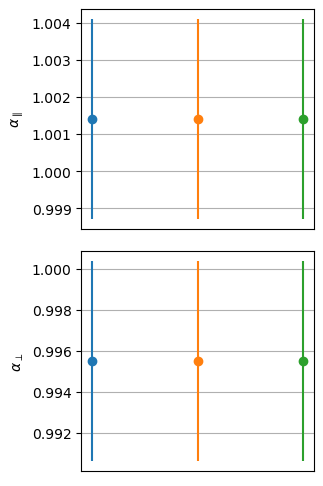

In [5]:
from desilike.samples import plotting
plotting.plot_aligned_stacked(profiler.profiles, params=['qpar', 'qper'])

array([<AxesSubplot:ylabel='$k \\Delta P_{0}(k)$ [$(\\mathrm{Mpc}/h)^{2}$]'>,
       <AxesSubplot:xlabel='$k$ [$h/\\mathrm{Mpc}$]', ylabel='$k \\Delta P_{2}(k)$ [$(\\mathrm{Mpc}/h)^{2}$]'>],
      dtype=object)

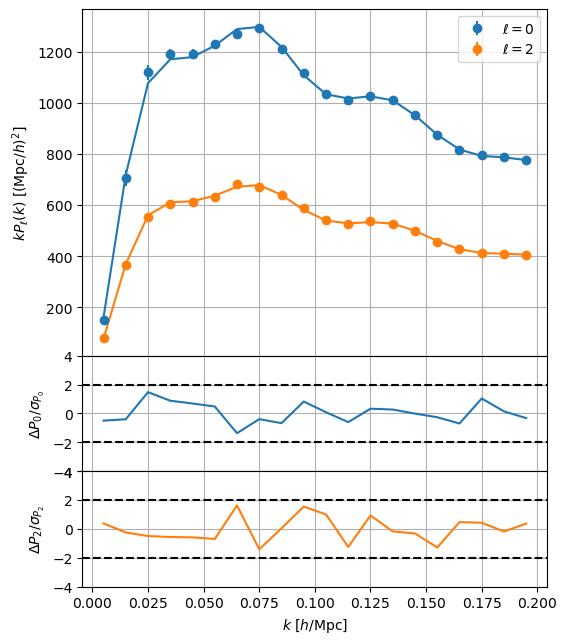

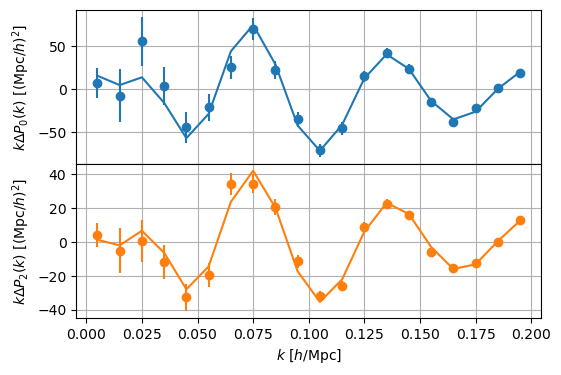

In [6]:
likelihood(**profiler.profiles.bestfit.choice(params=likelihood.varied_params))
observable.plot()
observable.plot_bao()

## Detection level

In [7]:
template = BAOPowerSpectrumTemplate(z=z, fiducial='DESI', apmode='qiso')
theory.update(template=template, wiggle=False)

profiler = MinuitProfiler(likelihood, seed=42)
grid = np.linspace(0.8, 1.2, 31)
profiler.maximize(niterations=1)
profiler.profile(params=['qiso'], grid=grid)
profiles_nowiggle = profiler.profiles

[000012.29] [0/1] 12-05 10:18  GaussianLikelihood        INFO     Covariance matrix with 40 points built from 1000 observations.
[000012.30] [0/1] 12-05 10:18  GaussianLikelihood        INFO     ...resulting in Hartlap factor of 0.9590.
[000012.76] [0/1] 12-05 10:18  MinuitProfiler            INFO     Varied parameters: ['qiso', 'b1', 'al0_-1', 'al0_0', 'al0_1', 'al2_-1', 'al2_0', 'al2_1'].


In [8]:
theory.update(wiggle=True)

profiler = MinuitProfiler(likelihood, seed=42)
profiler.maximize(niterations=1)
print(profiler.profiles.to_stats(tablefmt='pretty'))

profiler.profile(params=['qiso'], grid=grid)
profiles = profiler.profiles

[000070.74] [0/1] 12-05 10:19  GaussianLikelihood        INFO     Covariance matrix with 40 points built from 1000 observations.
[000070.74] [0/1] 12-05 10:19  GaussianLikelihood        INFO     ...resulting in Hartlap factor of 0.9590.
[000070.78] [0/1] 12-05 10:19  MinuitProfiler            INFO     Varied parameters: ['qiso', 'b1', 'al0_-1', 'al0_0', 'al0_1', 'al2_-1', 'al2_0', 'al2_1'].
+--------------+--------+---------+--------+
| chi2 = 25.96 | varied | bestfit | error  |
+--------------+--------+---------+--------+
|     qiso     |  True  | 1.0025  | 0.0027 |
|      b1      |  True  |  1.995  | 0.020  |
|    al0_-1    |  True  |   180   |  160   |
|    al0_0     |  True  |  -230   |  220   |
|    al0_1     |  True  |   88    |   94   |
|    al2_-1    |  True  |   53    |   58   |
|    al2_0     |  True  |   -38   |  90.   |
|    al2_1     |  True  |   14    |   36   |
+--------------+--------+---------+--------+


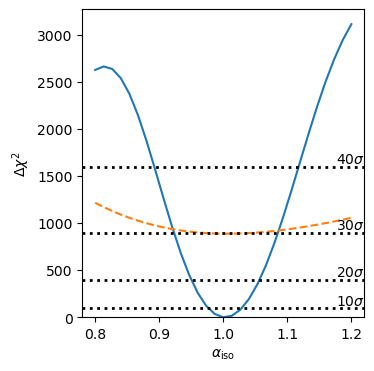

In [9]:
plotting.plot_profile_comparison(profiles, profiles_nowiggle, cl=[10, 20, 30, 40])
# Orange curve, which is no-wiggle, is not flat:
# some qiso information is picked up by the broadband because we did not include enough broadband terms

## Sampling
Let us draw MC samples of the likelihood (actually posterior, including parameter priors).

In [10]:
from desilike.samplers import ZeusSampler

#theory = DampedBAOWigglesTracerPowerSpectrumMultipoles(template=template)
# Fix some broadband parameters (those with k^{-3}, k^{-2} and k^{-1}) to speed up inference in this notebook
#for param in theory.params.select(basename=['al*_-3', 'al*_-2', 'al*_-1']):
#    param.value = 0.
#    param.fixed = True
#observable.update(theory=theory)

sampler = ZeusSampler(likelihood, save_fn='_tests/chain_bao_*.npy', seed=42)
sampler.run(check={'max_eigen_gr': 0.05, 'stable_over': 1})

[000130.17] [0/1] 12-05 10:20  ZeusSampler               INFO     Varied parameters: ['qiso', 'b1', 'al0_-1', 'al0_0', 'al0_1', 'al2_-1', 'al2_0', 'al2_1'].
[000130.30] [0/1] 12-05 10:20  root                      INFO     Initialising ensemble of 20 walkers...
[000264.98] [0/1] 12-05 10:22  Chain                     INFO     Saving _tests/chain_bao_0.npy.
[000264.98] [0/1] 12-05 10:22  ZeusSampler               INFO     Diagnostics:
[000264.99] [0/1] 12-05 10:22  ZeusSampler               INFO     - max eigen Gelman-Rubin - 1 is 2.64; not < 0.05.
[000265.00] [0/1] 12-05 10:22  ZeusSampler               INFO     - max diag Gelman-Rubin - 1 is 0.0454.
[000265.03] [0/1] 12-05 10:22  ZeusSampler               INFO     - max diag Gelman-Rubin - 1 at 1.0 sigmas is 0.0109.
[000265.04] [0/1] 12-05 10:22  ZeusSampler               INFO     - max Geweke is 0.202.
[000265.04] [0/1] 12-05 10:22  ZeusSampler               INFO     - Geweke p-value is 0.0107.
[000265.09] [0/1] 12-05 10:22  ZeusSamp

[000990.29] [0/1] 12-05 10:34  ZeusSampler               INFO     - (1200 iterations / integrated autocorrelation time) (reliable) is 75.
[000990.29] [0/1] 12-05 10:34  ZeusSampler               INFO     - max variation of integrated autocorrelation time is 0.107.
[000990.37] [0/1] 12-05 10:34  root                      INFO     Initialising ensemble of 20 walkers...
[001097.14] [0/1] 12-05 10:36  Chain                     INFO     Saving _tests/chain_bao_0.npy.
[001097.16] [0/1] 12-05 10:36  ZeusSampler               INFO     Diagnostics:
[001097.17] [0/1] 12-05 10:36  ZeusSampler               INFO     - max eigen Gelman-Rubin - 1 is 0.132; not < 0.05.
[001097.19] [0/1] 12-05 10:36  ZeusSampler               INFO     - max diag Gelman-Rubin - 1 is 0.0144.
[001097.25] [0/1] 12-05 10:36  ZeusSampler               INFO     - max diag Gelman-Rubin - 1 at 1.0 sigmas is 0.0326.
[001097.26] [0/1] 12-05 10:36  ZeusSampler               INFO     - max Geweke is 0.223.
[001097.26] [0/1] 12-05 

[001875.33] [0/1] 12-05 10:49  ZeusSampler               INFO     - max diag Gelman-Rubin - 1 at 1.0 sigmas is 0.0359.
[001875.34] [0/1] 12-05 10:49  ZeusSampler               INFO     - max Geweke is 0.109.
[001875.34] [0/1] 12-05 10:49  ZeusSampler               INFO     - Geweke p-value is 0.538.
[001875.42] [0/1] 12-05 10:49  ZeusSampler               INFO     - (2400 iterations / integrated autocorrelation time) (reliable) is 141.
[001875.42] [0/1] 12-05 10:49  ZeusSampler               INFO     - max variation of integrated autocorrelation time is 0.0246.
[001875.50] [0/1] 12-05 10:49  root                      INFO     Initialising ensemble of 20 walkers...
[001994.08] [0/1] 12-05 10:51  Chain                     INFO     Saving _tests/chain_bao_0.npy.
[001994.11] [0/1] 12-05 10:51  ZeusSampler               INFO     Diagnostics:
[001994.13] [0/1] 12-05 10:51  ZeusSampler               INFO     - max eigen Gelman-Rubin - 1 is 0.112; not < 0.05.
[001994.14] [0/1] 12-05 10:51  Zeu

In [11]:
chain = sampler.chains[0].remove_burnin(0.5)
print(chain.to_stats(tablefmt='pretty'))

+--------+--------+--------+--------+--------+-----------------+-----------------+
|        | argmax |  mean  | median |  std   | quantile:1sigma | interval:1sigma |
+--------+--------+--------+--------+--------+-----------------+-----------------+
|  qiso  | 1.0021 | 1.0025 | 1.0025 | 0.0027 | -0.0027/+0.0027 | -0.0028/+0.0026 |
|   b1   | 1.990  | 1.994  | 1.994  | 0.020  |  -0.020/+0.020  |  -0.019/+0.022  |
| al0_-1 |  180   |  190   |  190   |  160   |    -170/+170    |    -160/+170    |
| al0_0  |  -160  |  -230  |  -240  |  220   |    -220/+220    |    -220/+210    |
| al0_1  |   58   |   87   |   88   |   92   |     -92/+92     |     -87/+97     |
| al2_-1 |   46   |   54   |   53   |   58   |     -57/+58     |     -62/+54     |
| al2_0  |  -16   |  -38   |  -37   |   89   |     -89/+89     |     -87/+91     |
| al2_1  |   7    |   14   |   14   |   35   |     -35/+35     |     -37/+34     |
+--------+--------+--------+--------+--------+-----------------+-----------------+


[002243.10] [0/1] 12-05 10:55  numexpr.utils             INFO     NumExpr defaulting to 8 threads.
Removed no burn in


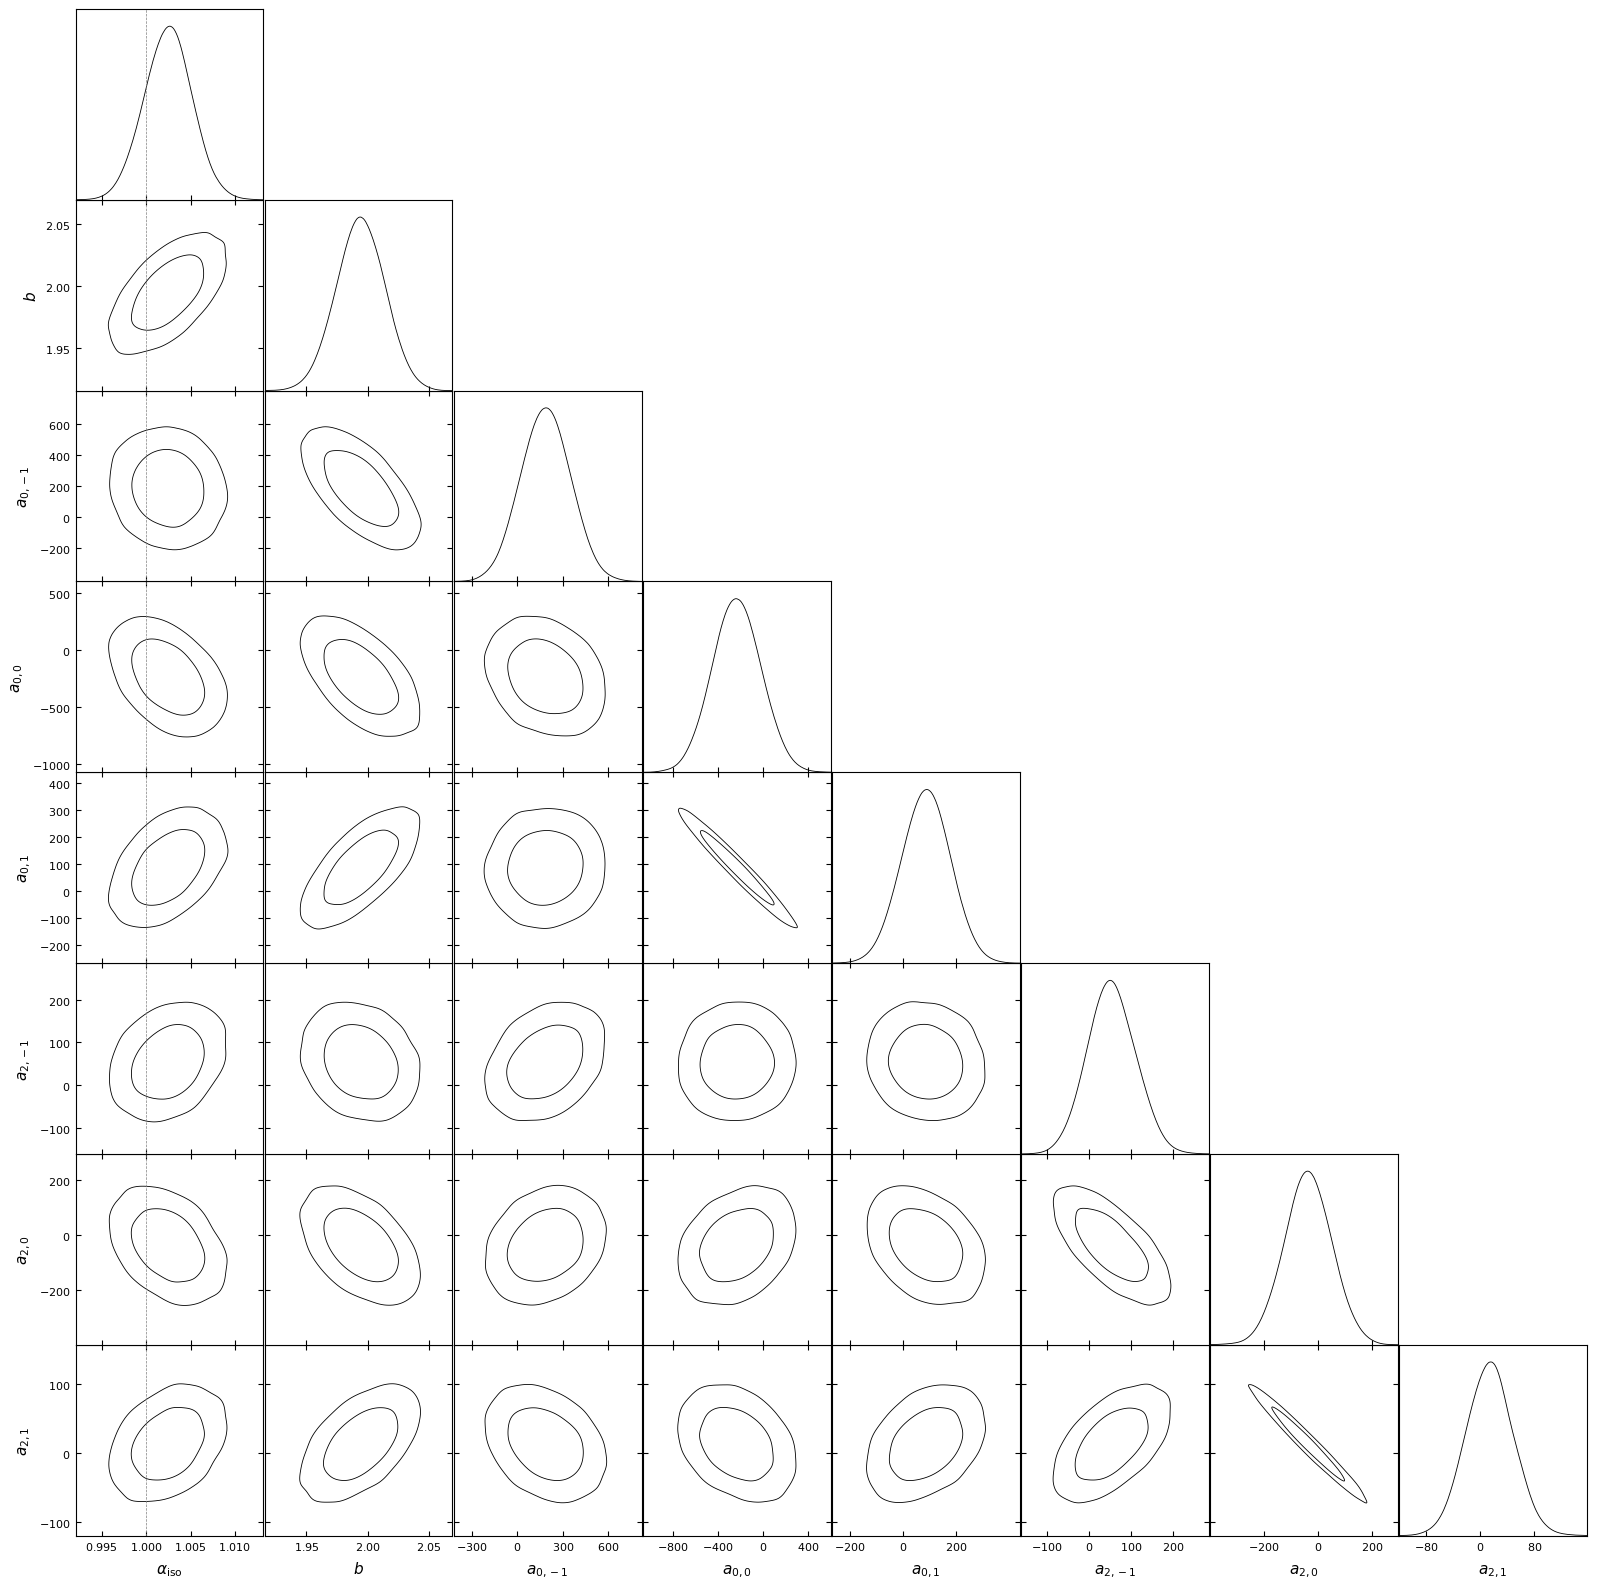

In [12]:
from desilike.samples import plotting
plotting.plot_triangle(chain, markers={'qiso': 1.})